# Chapter 12 – Distributed TensorFlow

在第11章我们讨论了几种可以大大加快培训速度的技术：更好的权重初始化，批量标准化，复杂的优化器和等等。然而，即使使用所有这些技术，使用单个CPU在单台机器上训练大型神经网络也可能需要数天甚至数周。

在本章中，我们将看到如何使用TensorFlow在多个设备（CPU和GPU）之间分配计算并并行运行它们（参见图12-1）。

* 首先，我们将在一台机器的多个设备上分配计算，
* 然后在多台机器上的多个设备上分配计算。
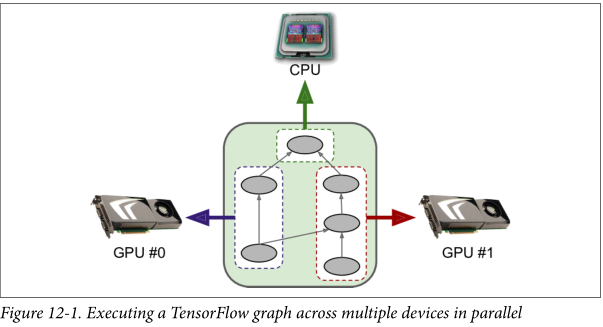

与其他神经网络框架相比，TensorFlow对分布式计算的支持是其主要亮点之一。它使你
* 可以完全控制如何跨设备和服务器拆分（或复制）计算图，
* 并允许你以灵活的方式并行化和同步操作，以便你可以在各种并行化方法之间进行选择。

我们将介绍一些最流行的并行化神经网络执行和训练的方法。
* 你可能最终只等待几个小时，而不是等待数周才能完成训练算法。
* 这不仅节省了大量时间，还意味着你可以更轻松地试验各种模型，并经常在新模型上重新训练模型。

并行化的其他重要用例包括在微调模型时探索更大的超参数空间，以及有效地运行大型神经网络集合。
但是我们必须学会走路才能跑步。让我们**首先在一台机器上并行化几个GPU上的简单图形**。

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
CHAPTER_ID = "12_Distributed TensorFlow"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# 1. Multiple Devices on a Single Machine

只需添加 GPU 到单个机器上，你就可以获得主要的性能提升。 事实上，在很多情况下，这就足够了。 你根本不需要使用多台机器。 例如，通常在单台机器上使用 8 个 GPU，而不是在多台机器上使用 16 个 GPU（由于多机器设置中的网络通信带来的额外延迟），可以同样快地训练神经网络。

在本节中，
* 我们将介绍如何设置你的环境，以便 TensorFlow 可以在一台机器上使用多个GPU 。 
* 然后，我们将看看如何在可用设备上进行分布式操作，以及并行执行它们。

### 1.1 Installation

为了在多块 GPU 上运行 TensorFlow，**首先需要确保你的GPU 具有 NVidia 计算能力**（大于或等于3.0）。 这包括 Nvidia 的 Titan，Titan X，K20 和 K40（如果你拥有另一张卡，你可以在 https://developer.nvidia.com/cuda-gpus 查看它的兼容性）。

如果你没有任何 GPU 卡，
* 则可以使用具有 GPU 功能的主机服务器，如 Amazon AWS。 在 ŽigaAvsec 的[博客文章](https://goo.gl/kbge5b)中，提供了在 Amazon AWS GPU 实例上使用 Python 3.5 设置 TensorFlow 0.9 的详细说明。将它更新到最新版本的 TensorFlow 应该不会太难。 
* Google 还发布了一项名为 Cloud Machine Learning 的云服务来运行 TensorFlow 计算图。 2016 年 5 月，他们宣布他们的平台现在包括配备张量处理器（TPU）的服务器，专门用于机器学习的处理器，比许多 GPU 处理 ML 任务要快得多。 
* 当然，另一种选择就是购买你自己的 GPU 卡。 Tim Dettmers 写了一篇很棒的博客文章来帮助你选择，他会定期更新它。

你**必须下载并安装相应版本的 CUDA 和 cuDNN 库**（如果你使用的是 TensorFlow 1.0.0，则为 CUDA 8.0 和 cuDNN 5.1），并设置一些环境变量，以便 TensorFlow 知道在哪里可以找到 CUDA 和 cuDNN。 详细的安装说明可能会相当迅速地更改，因此最好按照 TensorFlow 网站上的说明进行操作。

Nvidia 的 CUDA 允许开发者使用支持 CUDA 的 GPU 进行各种计算（不仅仅是图形加速）。 Nvidia的CUDA深度神经网络库（cuDNN）是一个GPU加速的DNN原语库。 它提供了常用 DNN 计算的优化实现，例如激活层，归一化，前向和后向卷积以及池化（参见第 13 章）。 它是 Nvidia Deep Learning SDK 的一部分（请注意，它需要创建一个 Nvidia 开发者帐户才能下载它）。 TensorFlow 使用 CUDA 和 cuDNN 来控制 GPU 并加速计算（见图 12-2）。
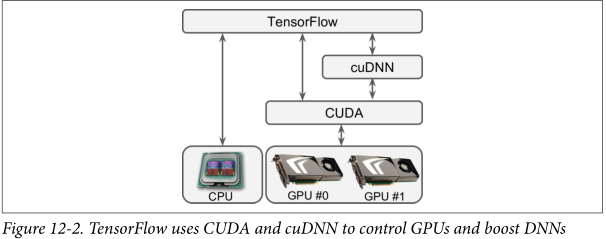

你可以使用`nvidia-smi`命令来检查 CUDA 是否已正确安装。 它列出了可用的 GPU 以及每张卡上运行的进程：
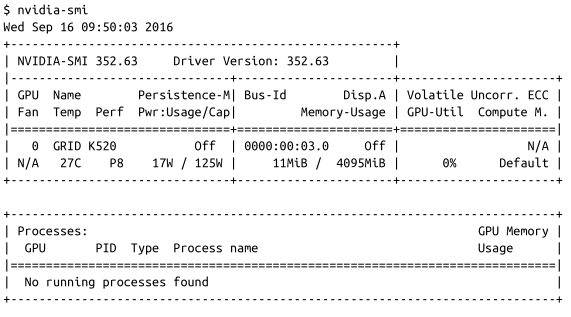

最后，你必须安装支持 GPU 的 TensorFlow。 如果你使用`virtualenv`创建了一个独立的环境，你首先需要激活它：
```
$ cd $ML_PATH # Your ML working directory (e.g., $HOME/ml)
$ source env/bin/activate
```

然后安装合适的支持 GPU 的 TensorFlow ：
```
$ pip3 install --upgrade tensorflow-gpu
```

现在你可以打开一个 Python shell 并通过导入 TensorFlow 并创建一个会话来检查 TensorFlow 是否正确检测并使用 CUDA 和 cuDNN：
```
>>> import tensorflow as tf 
I [...]/dso_loader.cc:108] successfully opened CUDA library libcublas.so locally 
I [...]/dso_loader.cc:108] successfully opened CUDA library libcudnn.so locally 
I [...]/dso_loader.cc:108] successfully opened CUDA library libcufft.so locally 
I [...]/dso_loader.cc:108] successfully opened CUDA library libcuda.so.1 locally 
I [...]/dso_loader.cc:108] successfully opened CUDA library libcurand.so locally 
```

```
>>> sess = tf.Session() 
[...] 
I [...]/gpu_init.cc:102] Found device 0 with properties: 
name: GRID K520 
major: 3 minor: 0 memoryClockRate (GHz) 0.797 
pciBusID 0000:00:03.0 
Total memory: 4.00GiB 
Free memory: 3.95GiB 
I [...]/gpu_init.cc:126] DMA: 0 
I [...]/gpu_init.cc:136] 0:   Y 
I [...]/gpu_device.cc:839] Creating TensorFlow device 
(/gpu:0) -> (device: 0, name: GRID K520, pci bus id: 0000:00:03.0)
```

看起来不错！TensorFlow 检测到 CUDA 和 cuDNN 库，并使用 CUDA 库来检测 GPU 卡（在这种情况下是 Nvidia Grid K520 显卡）。

### 1.2 Managing the GPU RAM - 管理 GPU 内存

默认情况下，TensorFlow 会在你第一次运行图形时自动获取所有可用 GPU 中的所有 RAM，因此当第一个程序仍在运行时，你将无法启动第二个 TensorFlow 程序。 如果你尝试，你会得到以下错误：

```
E [...]/cuda_driver.cc:965] failed to allocate 3.66G (3928915968 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY
```

**一种解决方案是在不同的 GPU 显卡上运行每个进程**。 为此，最简单的选择是设置`CUDA_VISIBLE_DEVICES`环境变量，以便每个进程只能看到对应的 GPU 显卡。 例如，你可以像这样启动两个程序：
```
$ CUDA_VISIBLE_DEVICES=0,1 python3 program_1.py 
# and in another terminal: 
$ CUDA_VISIBLE_DEVICES=3,2 python3 program_2.py
```

* 程序 #1 只会看到 GPU 显卡 0 和 1（分别编号为 0 和 1），
* 程序 #2 只会看到 GPU 显卡 2 和 3（分别编号为 1 和 0）。 

一切都会正常工作（见图 12-3）。
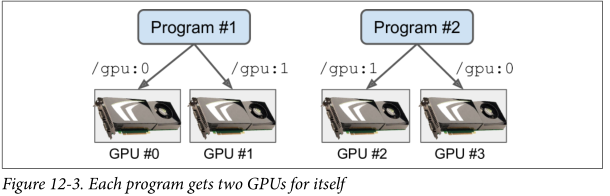

**另一种选择是告诉 TensorFlow 只抓取一小部分内存**。 例如，要使 TensorFlow 只占用每个 GPU 内存的 40%，你必须创建一个`ConfigProto`对象，将其`gpu_options.per_process_gpu_memory_fraction`选项设置为 0.4，并使用以下配置创建session：
```
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.4 
session = tf.Session(config=config)
```

现在像这样的两个程序（但不是三个，因为3×0.4> 1）可以使用相同的 GPU 显卡并行运行。 见图 12-4。
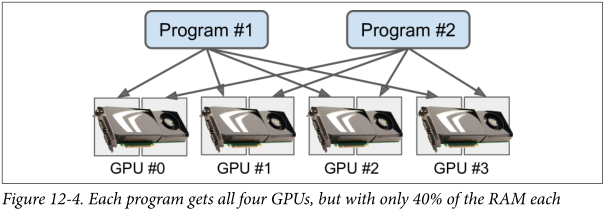

如果在两个程序都运行时运行`nvidia-smi`命令，则应该看到每个进程 大约占用每个显卡总 RAM的 40%：
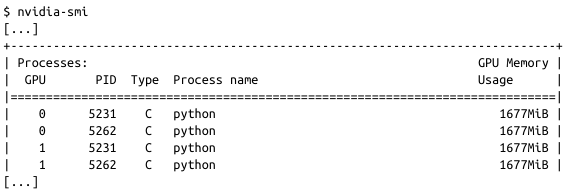

**另一种选择是告诉 TensorFlow 只在需要时才抓取内存**。 为此，
* 你必须将`config.gpu_options.allow_growth`设置为`True`。
* 但是，TensorFlow 一旦抓取内存就不会释放内存（以避免内存碎片），因此你可能会在一段时间后内存不足。

是否使用此选项可能难以确定，因此一般而言，你可能想要坚持之前的某个选项。

好的，现在你已经 安装了一个支持 GPU 的 TensorFlow。 让我们看看如何使用它！

### 1.3 Placing Operations on Devices - 在设备上布置操作

TensorFlow 白皮书介绍了一种友好的**动态布置器算法 - dynamic placer**，该算法能够
* 自动将操作分布到所有可用设备上，
* 并考虑到以前运行图中所测量的计算时间，
* 估算每次操作的输入和输出张量的大小， 
* 每个设备可用的 RAM，
* 传输数据进出设备时的通信延迟，
* 来自用户的提示和约束等等。 

不幸的是，这种复杂的算法是谷歌内部的，它并没有在 TensorFlow 的开源版本中发布。它被忽略的原因似乎是在实践中，用户指定的一小组放置规则实际上导致比动态放置器能够更有效的放置。 然而，TensorFlow 团队正在努力改进它，并且最终可能会被开放。

在此之前，TensorFlow依赖于简单的放置器，（顾名思义）是非常基本的。

**1.3.1 Simple placement - 简单放置**

每当你运行图表时如果TensorFlow需要评估尚未放置在设备上的节点，它将使用简单的放置器以及尚未放置的所有其他节点。
简单的放置器遵循以下规则：

* 如果某个节点已在先前运行的图表中放置在设备上，则该节点将保留在该设备上。
* 否则，如果用户将节点固定到设备（下面描述），则放置器将其放置那个装置。
* 否则，它默认为GPU＃0，如果没有GPU则默认为CPU。

正如你所看到的，将操作放在适当的设备上主要取决于你自己。 如果你不做任何事情，整个图表将被放置在默认设备上。 要将节点固定到设备上，你必须使用`device()`函数创建一个设备块。 例如，以下代码将**变量 a**和**常量 b**固定在 CPU 上，但**乘法节点 c** 不固定在任何设备上，因此将放置在默认设备上：
```python
with tf.device("/cpu:0"):    
    a = tf.Variable(3.0)    
    b = tf.constant(4.0)
    
c = a * b
```

“/ cpu：0”设备聚合多CPU系统上的所有CPU。目前无法在特定CPU上固定节点或仅使用所有CPU的子集。

**1.3.2 Logging placements - 记录放置位置**

让我们检查一下简单的放置器是否遵守我们刚刚定义的布局约束条件。 为此，你可以将`log_device_placement`选项设置为`True`；这告诉放置器在放置节点时记录消息。例如：
```
>>> config = tf.ConfigProto() 
>>> config.log_device_placement = True 
>>> sess = tf.Session(config=config) 
I [...] Creating TensorFlow device (/gpu:0) -> (device: 0, name: GRID K520, pci bus id: 0000:00:03.0) 
[...] 
>>> x.initializer.run(session=sess) 
I [...] a: /job:localhost/replica:0/task:0/cpu:0 
I [...] a/read: /job:localhost/replica:0/task:0/cpu:0 
I [...] mul: /job:localhost/replica:0/task:0/gpu:0 
I [...] a/Assign: /job:localhost/replica:0/task:0/cpu:0 
I [...] b: /job:localhost/replica:0/task:0/cpu:0 
I [...] a/initial_value: /job:localhost/replica:0/task:0/cpu:0 
>>> sess.run(c) 
12
```

**以“I”开头的Info是日志消息**。当我们创建会话时，
* TensorFlow会记录一条消息，告诉我们它已经找到了一张GPU显卡（在本例中是Grid K520卡）。

* 然后我们第一次运行图形（在这种情况下初始化变量a时）， 运行简单的放置器并将每个节点放在分配给它的设备上。

正如所料，
* 日志消息显示所有节点都放在“/ cpu：0”上，
* 但乘法节点除外，它最终在默认设备“/ gpu：0”上（你现在可以安全地忽略前缀`/job：localhost / replica：0 / task：0` ;我们马上就会谈到它）。

请注意，第二次运行图形（计算 **c**）时，不使用放置器，因为TensorFlow需要计算的所有节点c已经被放置了。

**1.3.3 Dynamic placement function - 动态放置函数**

创建设备块时，可以指定函数而不是设备名称。TensorFlow将为需要放置在设备块中的每个操作调用此函数，**该函数必须返回设备的名称以固定操作**。

例如，以下代码将**所有变量节点**固定为“/ cpu：0”（在这种情况下只是变量a）和**所有其他节点**固定到“/ gpu：0”：
```python
def variables_on_cpu(op):    
    if op.type == "Variable":        
        return "/cpu:0"    
    else:        
        return "/gpu:0"
        
with tf.device(variables_on_cpu): 
    a = tf.Variable(3.0)
    b = tf.constant(4.0)    
    c = a * b
```

你可以轻松实现更复杂的算法，例如以循环方式用GPU锁定变量。

**1.3.4 Operations and kernels - 操作和内核**

要在设备上运行TensorFlow操作，它需要有一个该设备的实现; 这叫做**内核**。许多操作都有内核用于CPU和GPU，但不是全部。

例如，**TensorFlow没有用于整数变量的GPU内核**，因此当TensorFlow尝试将变量 $i$ 放在GPU＃0上时，以下代码将失败：

```python
>>> with tf.device("/gpu:0"):
... i = tf.Variable(3)
[...]
>>> sess.run(i.initializer)
Traceback (most recent call last):
[...]
tensorflow.python.framework.errors.InvalidArgumentError: Cannot assign a device
to node 'Variable': Could not satisfy explicit device specification
```

请注意，TensorFlowr认为变量必须是int32类型，因为初始化值是一个整数。**如果将初始化值更改为3.0而不是3，或者在创建变量时显式设置`dtype = tf.float32`，则一切都会正常工作**。

**1.3.5 Soft placement - 软放置**

默认情况下，
* 如果你尝试在操作没有内核的设备上固定操作，则在TensorFlow尝试将操作放在设备上时会出现前面显示的异常。 
* 如果你更喜欢TensorFlow回退到CPU，则可以将`allow_soft_placement`配置选项设置为`True`

```python
with tf.device("/gpu:0"):    
    i = tf.Variable(3)
    
config = tf.ConfigProto() 
config.allow_soft_placement = True 
sess = tf.Session(config=config) 
sess.run(i.initializer)  # the placer runs and falls back to /cpu:0 
```

到目前为止，我们已经讨论了如何在不同设备上放置节点。 现在让我们看看 TensorFlow 如何并行运行这些节点。

### 1.4 Parallel Execution - 并行运行

当TensorFlow运行图表时
* 它首先找出需要评估的节点列表，
* 然后计算每个节点的依赖关系数。
* 然后，TensorFlow开始评估具有零依赖性的节点（即，源节点）。
  * 如果这些节点放在不同的设备上，它们显然会被并行评估。
  * 如果将它们放在同一设备上，则会在不同的线程中对它们进行评估，因此它们也可以并行运行（在单独的GPU线程或CPU内核中）。

TensorFlow管理每个设备上的线程池以并行化操作（请参阅图12-5）。 这些称为**inter-op thread pools**。某些操作具有多线程内核：它们可以使用称为**intra-opthread pools**的其他线程池（每个设备一个）。

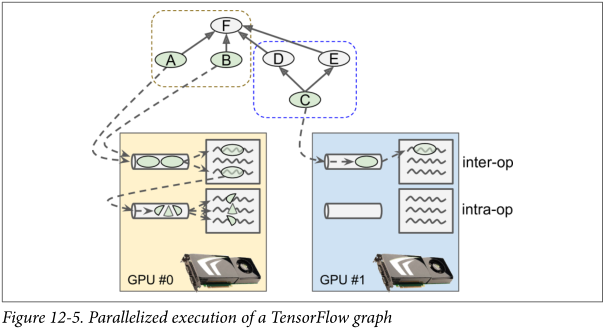

例如，在图12-5中，
* 操作A，B和C是源操作，因此它们可以立即进行评估。

* 操作A和B放在GPU＃0上，因此它们被发送到该设备的操作间线程池，并立即并行评估。

* 操作A恰好有一个多线程内核; 它的计算分为三部分，由运算内线程池并行执行。 

* 操作C进入GPU＃1的操作间线程池。

* 一旦操作C完成，操作D和E的依赖性计数器将立即执行递减并且都将达到0，因此两个操作都将被发送到操作间要执行的线程池。

* 你可以通过设置`inter_op_parallelism_threads`选项来控制内部线程池的线程数。 请注意，你开始的第一个会话将创建内部线程池。 除非你将`use_per_session_threads`选项设置为`True`，否则所有其他会话都将重用它们。 
* 你可以通过设置`intra_op_parallelism_threads`选项来控制每个内部线程池的线程数。

### 1.5 Control Dependencies - 控制依赖关系

**在某些情况下，推迟对操作的评估可能是明智的，即使它所依赖的所有操作都已执行**。

* 例如，如果它使用大量内存但是图中只需要更多的值，那么最好在最后一刻对其进行评估，以避免不必要地占用其他操作可能需要的RAM。

* 另一个示例是一组依赖于位于设备外部的数据的操作。如果它们全部同时运行，它们可能会使设备的通信带宽饱和，并且它们最终都会等待I / O.其他需要传输数据的操作也将被阻止。最好是顺序执行这些通信繁重的操作，允许设备并行执行其他操作。

**要推迟对某些节点的评估，一个简单的解决方案是添加控制依赖关系**。

例如，以下代码告诉TensorFlow**仅在评估 a 和 b 之后评估 x 和 y **：

```python
a = tf.constant(1.0) 
b = a + 2.0

with tf.control_dependencies([a, b]):    
    x = tf.constant(3.0)    
    y = tf.constant(4.0)

z = x + y
```
* 显然，由于`z`依赖于`x`和`y`，因此评估`z`还意味着等待`a`和`b`被评估，即使它未在`control_dependencies（）`块中显式地进行。

* 另外，由于`b`取决于`a`，我们可以通过在[b]而不是[a，b]上创建控件依赖来简化前面的代码，但在某些情况下“显式优于隐式”。

很好！ 现在你知道了：
* 如何以任何你喜欢方式在多个设备上进行操作
* 这些操作如何并行执行
* 如何创建控件依赖关系以优化并行执行

是时候在多个服务器上分配计算了！

## 2. Multiple Devices Across Multiple Servers - 多台服务器上的多个设备

要跨多个服务器运行图形，首先需要定义一个**集群**。
* 集群由一个或多个TensorFlow服务器组成，称为**任务**，通常分布在多台计算机上（参见图12-6）。
* 每项任务都属于一项**作业 - job**。 作业只是一组通常具有共同角色的命名任务，例如跟踪模型参数（这样的作业通常被命名为参数服务器的**“ps”**），或者执行计算（这样的作业通常被命名为**“worker“**）。

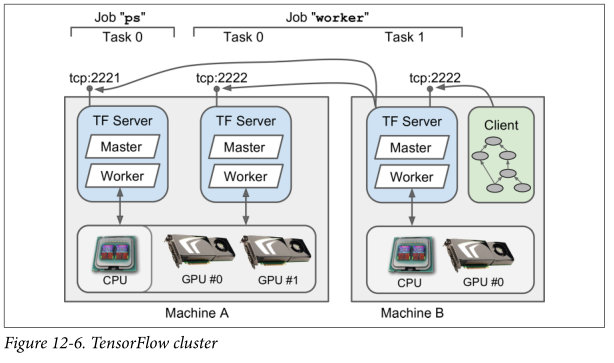

以下集群规范定义了两个作业"ps"和"worker"，分别包含一个任务和两个任务。 在这个例子中，
* **机器A**托管着两个 TensorFlow 服务器（即任务），监听不同的端口：
  * 一个是"ps"作业的一部分，
  * 另一个是"worker"作业的一部分。 
* 机器B仅托管一台 TensorFlow 服务器，这是"worker"作业的一部分。

```python
cluster_spec = tf.train.ClusterSpec({    
    "ps": [        
        "machine-a.example.com:2221",  # /job:ps/task:0    
        ],    
    "worker": [        
        "machine-a.example.com:2222",  # /job:worker/task:0        
        "machine-b.example.com:2222",  # /job:worker/task:1    
        ]}) 
```

要启动 TensorFlow 服务器，你必须创建一个服务器对象，并向其传递集群规范（以便它可以与其他服务器通信）以及它自己的作业名称和任务编号。 例如，要启动第一个辅助任务，你需要在机器 A 上运行以下代码：
```python
server = tf.train.Server(cluster_spec, job_name="worker", task_index=0) 
```

每台机器只运行一个任务通常比较简单，但前面的例子表明 TensorFlow 允许你在同一台机器上运行多个任务（如果需要的话）。
* 如果你在一台机器上安装了多台服务器，则需要**确保它们不会全部尝试抓取每个 GPU 的所有 RAM**，如前所述。 例如，在图12-6中，"ps"任务没有看到 GPU 设备，想必其进程是使用`CUDA_VISIBLE_DEVICES =""`启动的。 请注意，**CPU由位于同一台计算机上的所有任务共享**。

* 如果你希望进程除了运行 TensorFlow 服务器之外什么都不做，您可以通过告诉它等待服务器使用join（）方法来阻止主线程（否则一旦主线程退出，服务器就会被终止）。 由于目前没有办法阻止服务器，这实际上会永远阻止：
```
server.join()  # blocks until the server stops (i.e., never) 
```

### 2.1 Opening a Session

一旦所有任务启动并运行（但还什么都没做），你可以从位于任何机器上的任何进程（甚至是运行中的进程）中的客户机上的任何服务器上打开会话，使用该会话像普通的本地会议一样。比如：
```python
a = tf.constant(1.0) 
b = a + 2 
c = a * 3

with tf.Session("grpc://machine-b.example.com:2222") as sess:    
    print(c.eval())  # 9.0 
    
```

这个客户端代码
* 首先创建一个简单的图形，
* 然后在位于机器 B（我们称之为**主机 - master**）上的 TensorFlow 服务器上打开一个会话，并指示它评估`c`。 
  * 主设备首先将操作放在适当的设备上。 在这个例子中，因为我们没有在任何设备上进行任何操作，所以主设备只将它们全部放在它自己的默认设备上 - 在这种情况下是机器 B 的 GPU 设备。 
  * 然后它只是按照客户端的指示评估c，然后返回结果。

### 2.2 The Master and Worker Services - 主机和工作服务

客户端使用 gRPC 协议（Google Remote Procedure Call）与服务器进行通信。 
* 这是一个高效的开源框架，可以调用远程函数，并通过各种平台和语言获取它们的输出。
* 它基于 HTTP2，打开一个连接并在整个会话期间保持打开状态，一旦建立连接就可以进行高效的双向通信。
* 数据以协议缓冲区的形式传输，这是另一种开源 Google 技术。 这是一种轻量级的二进制数据交换格式。

TensorFlow 集群中的所有服务器都可能与集群中的任何其他服务器通信，因此请确保在防火墙上打开适当的端口。

每个TensorFlow服务器都提供两种服务：主服务和工作服务。主服务允许客户端打开会话并使用它们来运行图形。它协调跨任务的计算，实际依赖于工作服务对其他任务执行计算并获得结果。

这种架构为您提供了很大的灵活性。
* 一个客户端可以通过在不同线程中打开多个会话来连接到多个服务器 
* 一台服务器可以同时处理来自一个或多个客户端的多个会话
* 你可以为每个任务运行一个客户端（通常在同一个进程中），或者只运行一个客户端来控制所有任务。 所有选项都是开放的。

### 2.3 Pinning Operations Across Tasks - 跨任务固定操作

通过指定作业名称，任务索引，设备类型和设备索引，可以使用设备块来锁定由任何任务管理的任何设备上的操作。 例如，以下代码
* 将`a`固定在"ps"作业（即机器 A 上的 CPU）中第一个任务的 CPU，
* 并将`b`固定在"worker"作业的第一个任务管理的第二个 GPU （这是 A 机上的 GPU#1）。
* 最后，`c`没有固定在任何设备上，所以主设备将它放在它自己的默认设备上（机器 B 的 GPU#0 设备）。`

```python
with tf.device("/job:ps/task:0/cpu:0")    
    a = tf.constant(1.0)
    
with tf.device("/job:worker/task:0/gpu:1")    
    b = a + 2
    
c = a + b
```

如前所述，
* 如果你**省略设备类型和索引**，则 TensorFlow 将默认为该任务的默认设备; 例如，将操作固定到"/job:ps/task:0"会将其放置在"ps"作业（机器 A 的 CPU）的第一个任务的默认设备上。 
* 如果你还**省略了任务索引**（例如，"/job:ps"），则 TensorFlow 默认为"/task:0"。
* 如果**省略作业名称和任务索引**，则 TensorFlow 默认为会话的主任务。

### 2.4 Sharding Variables Across Multiple Parameter Servers - 跨多个参数服务器的分片变量

正如我们很快会看到的那样，在分布式设置上训练神经网络时，
* 常见模式是将模型参数存储在一组参数服务器上（即"ps"作业中的任务），而其他任务则集中在计算上（即 ，"worker"工作中的任务）。 
* 对于具有数百万参数的大型模型，在多个参数服务器上分割这些参数非常有用，可以降低单个参数服务器网卡饱和的风险。

如果你要将每个变量手动固定到不同的参数服务器，那将非常繁琐。 幸运的是，TensorFlow 提供了`replica_device_setter()`函数，它以循环方式在所有"ps"任务中分配变量。 例如，**以下代码将五个变量引入两个参数服务器**：

```python
with tf.device(tf.train.replica_device_setter(ps_tasks=2):    
    v1 = tf.Variable(1.0)  # pinned to /job:ps/task:0    
    v2 = tf.Variable(2.0)  # pinned to /job:ps/task:1    
    v3 = tf.Variable(3.0)  # pinned to /job:ps/task:0    
    v4 = tf.Variable(4.0)  # pinned to /job:ps/task:1    
    v5 = tf.Variable(5.0)  # pinned to /job:ps/task:0
```

你可以传递集群规范`cluster = cluster_spec`而不是传递`ps_tasks`的数量，而TensorFlow将只计算“ps”作业中的任务数。

如果你在块中创建其他操作，除了变量之外，TensorFlow会自动将它们固定到“/ job：worker”，这将默认为“worker”作业中第一个任务管理的第一个设备。

你可以通过设置`worker_device`参数将它们固定到另一个设备，**但更好的方法是使用嵌入式设备块**。 内部设备块可以覆盖外部块中定义的作业，任务或设备。 例如：          

```python
with tf.device(tf.train.replica_device_setter(ps_tasks=2)):    
    v1 = tf.Variable(1.0)  # pinned to /job:ps/task:0 (+ defaults to /cpu:0)    
    v2 = tf.Variable(2.0)  # pinned to /job:ps/task:1 (+ defaults to /cpu:0)    
    v3 = tf.Variable(3.0)  # pinned to /job:ps/task:0 (+ defaults to /cpu:0)    
    [...]    
    s = v1 + v2            # pinned to /job:worker (+ defaults to task:0/gpu:0)    
    with tf.device("/gpu:1"):        
        p1 = 2 * s         # pinned to /job:worker/gpu:1 (+ defaults to /task:0)        
        with tf.device("/task:1"):            
            p2 = 3 * s     # pinned to /job:worker/task:1/gpu:1
            
```

此示例假定参数服务器仅为CPU，通常都是这种情况，因为它们只需要存储和传递参数，而不是执行密集计算。

### 2.5 Sharing State Across Sessions Using Resource Containers - 使用资源容器在会话中共享状态

当你使用普通本地会话（不是分布式）时，
* 每个变量的状态由会话本身管理;一旦结束，所有变量值都将丢失。
* 此外，多个本地会话不能共享任何状态，即使它们都运行相同的图表;每个会话都有自己的每个变量的副本（正如我们在第9章中讨论的那样）。

相反，当你使用分布式会话时，变量状态由位于群集本身的资源容器管理，而不是由会话管理。

因此，如果使用一个客户端会话创建名为`x`的变量，它将自动可用于同一群集上的任何其他会话（即使两个会话都连接到不同的服务器）。例如，请考虑以下客户端代码：

```python
# simple_client.py
import tensorflow as tf
import sys

x = tf.Variable(0.0, name="x")
increment_x = tf.assign(x, x + 1)

with tf.Session(sys.argv[1]) as sess:
    if sys.argv[2:]==["init"]:
        sess.run(x.initializer)
    sess.run(increment_x)
    print(x.eval())

```

假设你有一个TensorFlow集群，并在机器A和B，端口2222上运行。你可以启动客户端，让它在机器A上打开与服务器的会话，并告诉它初始化变量，增加它，并通过启动以下命令来打印它的值：
```python
$ python3 simple_client.py grpc://machine-a.example.com:2222 init
1.0
```


现在，如果使用以下命令启动客户端，它将连接到机器B上的服务器并神奇地重用相同的变量`x`（这次我们不要求服务器初始化变量）：
```python
$ python3 simple_client.py grpc://machine-b.example.com:2222
2.0
```

此功能可以削减两种方式：

如果你想在多个会话中共享变量，这很好，但是如果你想在同一个集群上运行完全独立的计算，你必须小心不要意外地使用相同的变量名。**确保你不会发生名称冲突的一种方法是将所有构造阶段包装在变量范围内，并为每个计算指定唯一名称**，例如：
```python
with tf.variable_scope("my_problem_1"):
    [...] # Construction phase of problem 1
```

更好的选择是使用容器块：
```python
with tf.container("my_problem_1"):
    [...] # Construction phase of problem 1
```

这将使用专用于问题＃1的容器，而不是默认容器（其名称为空字符串“”）。

* 一个优点是变量名称仍然很好而且很短。

* 另一个优点是你可以轻松地重置命名容器。

例如，以下命令将连接到计算机A上的服务器，并要求它重置名为“my_problem_1”的容器，该容器将释放此容器使用的所有资源（并关闭服务器上打开的所有会话）。必须先初始化此容器管理的所有变量，然后才能再次使用它：
```python
tf.Session.reset("grpc://machine-a.example.com:2222", ["my_problem_1"])
```


资源容器可以轻松地以灵活的方式跨会话共享变量。例如，图12-7显示了四个运行不同图形的客户端集群，但共享一些变量。

* 客户端A和B共享由默认容器管理的相同变量`x`，
* 而客户端C和D共享另一个名为`x`的容器，该容器由名为“my_problem_1”的容器管理。
* 请注意，客户端C甚至使用来自两个容器的变量。
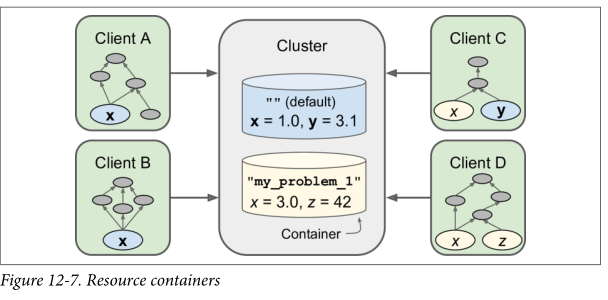

资源容器还负责保留其他有状态操作的状态，即队列和读取器。 我们先来看看队列。

### 2.6 Asynchronous Communication Using TensorFlow Queues - 使用TensorFlow队列进行异步通信

**队列**是在多个会话之间交换数据的另一种好方法;例如，一个常见的用例是
* 让一个客户端创建一个图表来加载训练数据并将其推入队列，
* 另一个客户端创建一个图表，从队列中提取数据并训练模型（见图12-8））。

这可以大大加快训练的速度，因为训练操作不必在每一步都等待下一个小批量生产。
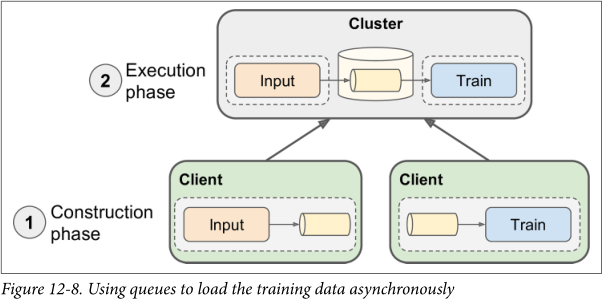

ensorFlow提供各种队列。**最简单的是先进先出（FIFO）队列**。 例如，以下代码创建一个FIFO队列，该队列最多可以存储10个包含两个浮点值的张量：

```python
q = tf.FIFOQueue(capacity=10, dtypes=[tf.float32], shapes=[[2]],
                 name="q", shared_name="shared_q")
```

**要跨会话共享变量，你所要做的就是在两端指定相同的名称和容器**。 对于队列，TensorFlow不使用`name`属性，而是使用`shared_nam`e，因此**指定它是很重要的**（即使它与名称相同）。

当然，使用相同的容器。

**2.6.1 Enqueuing data - 数据入队**

**要将数据推送到队列，你必须创建一个入队操作**。 例如，以下代码将三个训练实例推送到队列：
```python
# training_data_loader.py
import tensorflow as tf

q = [...]
training_instance = tf.placeholder(tf.float32, shape=(2))
enqueue = q.enqueue([training_instance])

with tf.Session("grpc://machine-a.example.com:2222") as sess:
    sess.run(enqueue, feed_dict={training_instance: [1., 2.]})
    sess.run(enqueue, feed_dict={training_instance: [3., 4.]})
    sess.run(enqueue, feed_dict={training_instance: [5., 6.]})
```

你可以使用`enqueue_many`操作一次排队几个,而不是逐个排列实例：
```python

[...]
training_instances = tf.placeholder(tf.float32, shape=(None, 2))
enqueue_many = q.enqueue([training_instances])

with tf.Session("grpc://machine-a.example.com:2222") as sess:
    sess.run(enqueue_many,
             feed_dict={training_instances: [[1., 2.], [3., 4.], [5., 6.]]})

```

**两个示例都将相同的三个张量排队到队列中**。

**2.6.2 Dequeuing data - 数据出队**

一般来说，你需要立刻拉出一个完整的小批量，而不是一次只拉一个实例。为此，你必须使用`dequeue_many`操作，指定小批量大小：
```python
[...]
batch_size = 2
dequeue_mini_batch= q.dequeue_many(batch_size)

with tf.Session("grpc://machine-a.example.com:2222") as sess:
    print(sess.run(dequeue_mini_batch)) # [[1., 2.], [4., 5.]]
    print(sess.run(dequeue_mini_batch)) # blocked waiting for another instance
```

* 队列已满时，入队操作将被阻止，直到元素被出列操作拉出。 
* 类似地，当队列为空（或者你正在使用`dequeue_many（）`并且元素的数量少于小批量大小时），出列操作将阻塞，直到使用入队操作将足够的元素推入队列。

** 2.6.3 Queues of tuples - 元组队列**

队列中的每个项目可以是张量（各种类型和形状）的元组，而不仅仅是单个张量。例如，以下队列存储**张量对**，
* 一个类型为`int32`和`shape（）`，
* 另一个类型为`float32`和`shape [3,2]`:

```python
q = tf.FIFOQueue(capacity=10, dtypes=[tf.int32, tf.float32], shapes=[[],[3,2]],
                 name="q", shared_name="shared_q")
```


**入队操作必须有成对的张量**（请注意，每对代表队列中只有一个项目）：


```python
a = tf.placeholder(tf.int32, shape=())
b = tf.placeholder(tf.float32, shape=(3, 2))
enqueue = q.enqueue((a, b))

with tf.Session([...]) as sess:
    sess.run(enqueue, feed_dict={a: 10, b:[[1., 2.], [3., 4.], [5., 6.]]})
    sess.run(enqueue, feed_dict={a: 11, b:[[2., 4.], [6., 8.], [0., 2.]]})
    sess.run(enqueue, feed_dict={a: 12, b:[[3., 6.], [9., 2.], [5., 8.]]})
```

另一方面，`dequeue（）`函数现在创建一对出列操作：
```python
dequeue_a, dequeue_b = q.dequeue()
```

通常，你应该一起运行这些操作：
```python
with tf.Session([...]) as sess:
    a_val, b_val = sess.run([dequeue_a, dequeue_b])
    print(a_val) # 10
    print(b_val) # [[1., 2.], [3., 4.], [5., 6.]]
```

* 如果你运行`dequeue_a`它自己，它会使一对出列并只返回第一个元素; 第二个元素将丢失.类似地，
* 如果你运行`dequeue_b`它自己，第一个元素将丢失）。

`dequeue_many（）`函数还返回一对操作：
```python
batch_size = 2
dequeue_as, dequeue_bs = q.dequeue_many(batch_size)
```

你可以按预期使用它：
```python
with tf.Session([...]) as sess: 
    a, b = sess.run([dequeue_a, dequeue_b])
    print(a) # [10, 11]
    print(b) # [[[1., 2.], [3., 4.], [5., 6.]], [[2., 4.], [6., 8.], [0., 2.]]]
    a, b = sess.run([dequeue_a, dequeue_b]) # blocked waiting for another pair
```

**2.6.4 Closing a queue - 关闭队列**

可以关闭队列以向其他会话发信号通知不再有数据入队：
```python
close_q = q.close()

with tf.Session([...]) as sess:
    [...]
    sess.run(close_q)
```

随后执行`enqueue`或`enqueue_many`操作将引发异常。
默认情况下，除非你调用`q.close（cancel_pending_enqueues = True）`，否则任何待处理的入队请求都将被接受


* 只要队列中有元素，后续执行的`dequeue`或`dequeue_many`操作将继续成功，但是当队列中没有足够的元素时它们会失败。

* 如果你正在使用`dequeue_many`操作，并且队列中还有一些实例，但少于小批量大小，则它们将丢失。

* 你可能更喜欢使用`dequeue_up_to`操作; 它的行为与`dequeue_many`完全相同，除非队列关闭且队列中剩余的`batch_size`实例少于此，在这种情况下它只返回它们。

**2.6.4 RandomShuffleQueue**

TensorFlow还支持更多类型的队列，包括`RandomShuffle`队列，可以像FIFOQueue一样使用，除了项目以随机顺序出列。
这对于在训练期间在每个时期改组训练实例是有用的。**首先**，让我们创建队列：

```python
q = tf.RandomShuffleQueue(capacity=50, min_after_dequeue=10,
                          dtypes=[tf.float32], shapes=[()],
                          name="q", shared_name="shared_q")

```
`min_after_dequeue`指定出列操作后必须保留在队列中的最小元素数。这可确保队列中有足够的实例具有足够的随机性（一旦队列关闭，将忽略`min_after_dequeue`限制）。现在假设你在这个队列中排队了22个元素（loats  1. to  22.）。以下是你如何将它们出列的结果：

```python
dequeue = q.dequeue_many(5)

with tf.Session([...]) as sess:
    print(sess.run(dequeue)) # [ 20. 15. 11. 12. 4.] (17 items left)
    print(sess.run(dequeue)) # [ 5. 13. 6. 0. 17.] (12 items left)
    print(sess.run(dequeue)) # 12 - 5 < 10: blocked waiting for 3 more instances
```

**2.6.5 Padding Fifo Queue - 填充Fifo队列 **

PaddingFIFOQueue也可以像FIFOQueue一样使用，除了它接受沿任何维度（但具有固定等级）的可变大小的张量。当你使用`dequeue_many`或`dequeue_up_to`操作将它们出列时，**每个张量在每个变量维度上用零填充，以使其与小批量中的最大张量相同**。例如，你可以将任意大小的2D张量（矩阵）排入队列：
```python
q = tf.PaddingFIFOQueue(capacity=50, dtypes=[tf.float32], shapes=[(None, None)]
                        name="q", shared_name="shared_q")
v = tf.placeholder(tf.float32, shape=(None, None))
enqueue = q.enqueue([v])

with tf.Session([...]) as sess:
    sess.run(enqueue, feed_dict={v: [[1., 2.], [3., 4.], [5., 6.]]}) # 3x2
    sess.run(enqueue, feed_dict={v: [[1.]]}) # 1x1
    sess.run(enqueue, feed_dict={v: [[7., 8., 9., 5.], [6., 7., 8., 9.]]}) # 2x4
```


* 如果我们一次只出列一个元素，我们得到已经入队的完全相同的张量。

* 但是如果我们一次出列几个元素（使用`dequeue_many（）`或`dequeue_up_to）`），队列自动适当地填充张量。

例如，如果我们一次将所有三个元素出列，则所有张量将用零填充以成为$3×4$张量，因为第一个维度的最大大小为3（第一个项目），第二个维度的最大大小为4 （第三项）：

```python
>>> q = [...]
>>> dequeue = q.dequeue_many(3)
>>> with tf.Session([...]) as sess:
... print(sess.run(dequeue))
[[[ 1. 2. 0. 0.]
  [ 3. 4. 0. 0.]
  [ 5. 6. 0. 0.]]

 [[ 1. 0. 0. 0.]
  [ 0. 0. 0. 0.]
  [ 0. 0. 0. 0.]]

 [[ 7. 8. 9. 5.]
  [ 6. 7. 8. 9.]
  [ 0. 0. 0. 0.]]]
```

当你处理可变长度输入时，例如单词序列（见第14章）,这种类型的队列可能很有用。

好的，现在让我们暂停一下到目前为止，你已经学会了：
* 跨多个设备和服务器分配计算，
* 跨会话共享变量，
* 以及使用队列异步通信。 

然而，在开始训练神经网络之前，我们需要讨论的最后一个主题是：**如何有效地加载训练数据**。

### 2.7 Loading Data Directly from the Graph - 直接从图表加载数据

到目前为止，**我们假设客户端将加载训练数据并使用占位符将其提供给群集**。这很简单，对于简单的设置非常有效，但由于它多次传输训练数据，所以效率很低：

1. 从文件系统到客户端
2. 从客户端到主任务
3. 可能从主任务到需要数据的其他任务

如果你有几个客户使用相同的训练数据训练各种神经网络（例如，用于超参数调整），它变得更糟：**如果每个客户端同时加载数据，你甚至可能会使文件服务器或网络带宽饱和**。

**2.7.1 Preload the data into a variable - 将数据预加载到变量中**


**对于可以适合内存的数据集，更好的选择是加载一次训练数据并将其分配给变量，然后在图表中使用该变量**。这称为**预加载训练集**。

这样，数据将仅从客户端传输到集群一次（但可能仍需要根据需要在哪个操作之间移动）。**以下代码显示如何将完整的训练集加载到变量中**：
```python
training_set_init = tf.placeholder(tf.float32, shape=(None, n_features))
training_set = tf.Variable(training_set_init, trainable=False, collections=[],
                           name="training_set")

with tf.Session([...]) as sess:
    data = [...] # load the training data from the datastore
    sess.run(training_set.initializer, feed_dict={training_set_init: data})
```

* 你必须设置`trainable = False`，以便优化器不会尝试调整此变量。

* 你还应该设置`collections = []`以确保不会将此变量添加到`GraphKeys.GLOBAL_VARIABLES`集合，这是用于保存和恢复检查点的。

此示例假定你的所有训练集（包括标签）仅包含`float32`值。 如果不是这种情况，则每种类型需要一个变量。


**2.7.2 Reading the training data directly from the graph - 直接从图表中读取训练数据**

**如果训练集不适合内存，一个好的解决方案是使用 reader 操作**：这些是能够直接从文件系统读取数据的操作。这样，训练数据根本不需要流过客户端。TensorFlow为**reader**提供各种文件格式：
* CSV
* 固定长度的二进制记录
* TensorFlow自己的TFRecords格式，基于协议缓冲区

让我们看一个从CSV文件中读取的简单示例（对于其他格式，请查看API文档）。

假设你有一个名为`my_test.csv`的文件，其中包含训练实例，并且你希望创建操作来读取它。假设它具有以下内容，具有两个浮点特征`x1`和`x2`以及一个表示二元类的整数目标：

```python
x1, x2, target
1. , 2. , 0
4. , 5 , 1
7. , , 0
```



**首先，让我们创建一个`TextLineReader`来读取这个文件**。`TextLineReader`打开一个文件（一旦我们告诉它打开哪一个）并逐个读取行。这是一个有状态的操作，如**变量和队列**：它在图形的多次运行中保留其状态，跟踪它当前正在读取的文件以及它在此文件中的当前位置。
```python
reader = tf.TextLineReader(skip_header_lines=1)
```

**接下来**，
* 我们创建一个队列，**reader**将从中拉出以知道接下来要读取的文件。
* 我们还创建了一个`enqueue`操作和一个占位符来将我们想要的任何文件名推送到队列，并且一旦我们没有更多要读取的文件，我们就会创建一个关闭队列的操作：
```python
filename_queue = tf.FIFOQueue(capacity=10, dtypes=[tf.string], shapes=[()])
filename = tf.placeholder(tf.string)
enqueue_filename = filename_queue.enqueue([filename])
close_filename_queue = filename_queue.close()
```

现在我们准备创建一个**read**操作，它将一次读取一条记录（即一条线）并返回一个键/值对(key/value pair)。

* **key**是记录的唯一标识符,这是一个字符串，包含：文件名，一个冒号（:)，行号 
* **value**只是一个包含行内容的字符串：
`key, value = reader.read(filename_queue)`

我们需要逐行读取文件！但我们尚未完成 ——我们需要解析此字符串以获取特征和目标：
```python
x1, x2, target = tf.decode_csv(value, record_defaults=[[-1.], [-1.], [-1]])
features = tf.stack([x1, x2])
```

第一行使用TensorFlow的**CSV解析器**从当前行中提取值。缺少字段时使用默认值（在本例中是第三个训练实例的`x2`特征），
它们还用于确定每个字段的类型（在本例中为两个浮点数和一个整数）。

最后，我们可以将这个训练实例及其目标推送到我们将与训练图分享的**RandomShuffleQueue**（这样它可以从中拉出mini-batches），**当我们完成向它推送实例时，我们创建一个关闭该队列的操作**：
```python
instance_queue = tf.RandomShuffleQueue(
    capacity=10, min_after_dequeue=2,
    dtypes=[tf.float32, tf.int32], shapes=[[2],[]],
    name="instance_q", shared_name="shared_instance_q")
enqueue_instance = instance_queue.enqueue([features, target])
close_instance_queue = instance_queue.close()
```

哇！这只是为了阅读文件而做的很多工作。 另外我们只创建了图表，所以现在我们需要运行它：

```python
with tf.Session([...]) as sess:
    sess.run(enqueue_filename, feed_dict={filename: "my_test.csv"})
    sess.run(close_filename_queue)
    try:
        while True:
            sess.run(enqueue_instance)
    except tf.errors.OutOfRangeError as ex:
        pass # 当前文件中没有更多记录，也没有更多要读取的文件
    sess.run(close_instance_queue)
```

* 首先我们打开会话，
* 然后我们将文件名“my_test.csv”排队并立即关闭该队列，因为我们不会将更多的文件名排入队列。

* 然后我们运行一个无限循环来逐个排列实例。`enqueue_instance`取决于读取下一行的reader，因此在每次迭代时都会读取新记录，直到它到达文件末尾。
  * 此时它尝试读取文件名队列以了解接下来要读取的文件，并且由于队列已关闭，因此会抛出OutOfRan geError异常（如果我们没有关闭队列，它将一直保持阻塞状态，直到我们推送另一个文件名或 关闭队列）。

* 最后，我们关闭实例队列，以便从中拉出的训练操作不会永远被阻止。 

图12-9总结了我们所学到的知识;它表示从一组CSV文件中读取训练实例的典型图形。

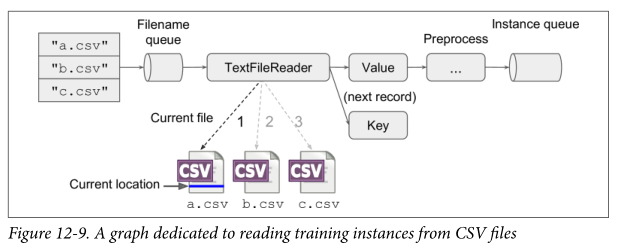

在这个训练图中，你需要创建共享实例队列并简单地从中取出 mini-batches批次：
```python
instance_queue = tf.RandomShuffleQueue([...], shared_name="shared_instance_q")
mini_batch_instances, mini_batch_targets = instance_queue.dequeue_up_to(2)
[...] # use the mini_batch instances and targets to build the training graph
training_op = [...]

with tf.Session([...]) as sess:
    try:
        for step in range(max_steps):
            sess.run(training_op)
    except tf.errors.OutOfRangeError as ex:
        pass # no more training instances
```
在这个例子中，第一个小批量将包含CSV文件的前两个实例，第二个小批量将包含最后一个实例。

TensorFlow队列不能很好地处理稀疏张量，因此如果你的训练实例是稀疏的，你应该在实例队列之后解析记录。


这种架构只会使用一个线程来读取记录并将它们推送到实例队列。通过使用多个 readers 从多个文件同时读取多个线程，您可以获得更高的吞吐量。 我们来看看如何。


**2.7.3 Multithreaded readers using a Coordinator and a QueueRunner - 使用Coordinator和QueueRunner的多线程读取器**


让多个线程同时读取实例，你可以创建Python线程（使用线程模块）并自己管理它们。但是，TensorFlow提供了一些工具来简化这个：**Coordinator类和 QueueR unner类**。

协调员是一个非常简单的对象，其唯一目的是协调停止多个线程。

**首先**创建一个`Coordinator`：
```python
coord = tf.train.Coordinator()`
```

**然后**你把它交给需要联合停止的所有线程，他们的主循环看起来像这样：
```python
while not coord.should_stop():
    [...] # do something
```
任何线程都可以通过调用`Coordinator`的`request_stop（）`方法请求每个线程停止：

```python
coord.request_stop()
```


每个线程一完成当前迭代就会停止。你可以通过调用Coordinator的join（）方法等待所有线程完成，并将线程列表传递给它：
```python
coord.join(list_of_threads)
```
* `QueueRunner`运行多个线程，每个线程重复运行一个入队操作，尽可能快地填满队列。
* 一旦队列关闭，尝试将项目推送到队列的下一个线程将获得`OutOfRangeError`;
  * 此线程捕获错误并立即告诉其他线程停止使用协调器。

以下代码显示了如何使用`QueueRunner`让五个线程同时读取实例并将它们推送到实例队列：

```python
[...] # same construction phase as earlier
queue_runner = tf.train.QueueRunner(instance_queue, [enqueue_instance] * 5)

with tf.Session() as sess:
    sess.run(enqueue_filename, feed_dict={filename: "my_test.csv"})
    sess.run(close_filename_queue)
    coord = tf.train.Coordinator()
    enqueue_threads = queue_runner.create_threads(sess, coord=coord, start=True)
    
```
* 第一行创建`QueueRunner`并告诉它运行五个线程，所有线程重复运行相同的enqueue_instance操作。

* 然后我们开始一个会话，我们将要读取的文件的名称排入队列（在本例中只是“my_test.csv”）。

* 接下来，我们创建一个协调器，`QueueRunner`将使用它来优雅地停止，正如刚刚解释的那样。

* 最后，我们告诉`QueueRunner`创建线程并启动它们。 线程将读取所有训练实例并将它们推送到实例队列，然后它们将全部正常停止。


这比以前更有效，**但我们可以做得更好**。
* 目前所有线程都从同一个文件读取。
* 我们可以通过**创建多个 reader 来同时从单独的文件中读取它们**（假设训练数据在多个CSV文件中分片）（参见图12-10）。

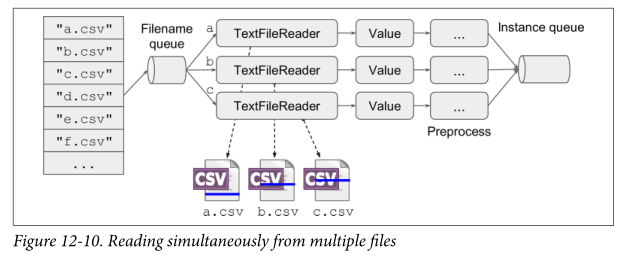

为此，我们**首先需要编写一个小函数**来创建一个读取器 - reader和将读取一个实例并将其推送到实例队列的节点：
```python
def read_and_push_instance(filename_queue, instance_queue): 
    reader = tf.TextLineReader(skip_header_lines=1)
    key, value = reader.read(filename_queue)
    x1, x2, target = tf.decode_csv(value, record_defaults=[[-1.], [-1.], [-1]])
    features = tf.stack([x1, x2])
    enqueue_instance = instance_queue.enqueue([features, target])
    return enqueue_instance

```
**接下来**我们定义队列：
```python
filename_queue = tf.FIFOQueue(capacity=10, dtypes=[tf.string], shapes=[()])
filename = tf.placeholder(tf.string)
enqueue_filename = filename_queue.enqueue([filename])
close_filename_queue = filename_queue.close()

instance_queue = tf.RandomShuffleQueue([...])
```

**最后我们创建了`QueueRunner`** ，但是这一次我们给它列出了不同的入队操作。每个操作都将使用不同的读取器，因此线程将同时从不同的文件中读取：
```python
read_and_enqueue_ops = [
    read_and_push_instance(filename_queue, instance_queue)
    for i in range(5)]
queue_runner = tf.train.QueueRunner(instance_queue, read_and_enqueue_ops)

```

然后执行阶段与之前相同：
* 首先推送要读取的文件的名称，
* 然后创建一个`Coordinator`并创建并启动`QueueRunner`线程。这次所有线程将同时从不同的文件中读取直到完全读取所有文件
* 然后`QueueRunner`将关闭实例队列，以便从中拉出的其他操作不会被阻止。

**2.7.4 Other convenience functions - 其他便利函数**

TensorFlow还提供了一些便利函数，以简化读取训练实例时的一些常见任务。我们将介绍几个（请参阅API文档以获取完整列表）。

1.  `string_input_producer（）`采用包含文件名列表的1D张量，创建一个线程，一次将一个文件名推送到文件名队列，然后关闭队列。
    * 如果指定了多个 epochs，它将在关闭队列之前每个 epoch循环一次文件名。

    * 默认情况下，它会在每个 epoch随机播放文件名。
    * 它创建一个QueueRunner来管理它的线程，并将其添加到`Graph Keys.QUEUE_RUNNERS `集合.  要启动该集合中的每个QueueRunner，可以调用`tf.train.start_queue_runners（）`函数。请注意，如果你忘记启动QueueRunner，文件名队列将打开并清空，你的reader 将被永久阻止。
    
2. 还有一些其他生成器函数可以类似地创建队列以及用于运行入队操作的相应QueueRunner（例如，`input_producer（），range_input_producer（）和slice_input_producer（）`）。

3. `shuffle_batch（）`函数获取张量列表（例如，[features，target]）并创建：

   *  一个 `RandomShuffleQueue`

   *  一个`QueueRunner`将张量排入队列（添加到`Graph Keys.QUEUE_RUNNERS`集合中）

   *  一个`dequeue_many`操作，用于从队列中提取小批量

这使得在单个进程中管理多线程输入管道，为该队列提供队列和训练管道读取小批量变得容易。还可以查看提供类似功能的`batch（），batch_join（）`和`shuffle_batch_join（）`函数。

好的！ 你现在拥有了在TensorFlow集群上的多个设备和服务器上有效开始训练和运行神经网络所需的所有工具。 让我们来看看你学到了什么：

* 使用多个GPU设备

* 设置和启动TensorFlow集群

* 跨多个设备和服务器分配计算

* 使用容器跨会话共享变量（以及其他有状态操作，如队列和读取器）
 
* 协调使用队列异步工作的多个图

* 跨多个服务器的多个设备

* 使用阅读器，队列运行器和协调器有效地读取输入

现在让我们使用所有这些来并行化神经网络！


# 3. Parallelizing Neural Networks on a TensorFlow Cluster
#     在TensorFlow集群上并行化神经网络

在这部分，

* 首先，我们将通过简单地**将每个神经网络放置在不同的设备上来研究如何并行化几个神经网络**。
* 然后我们将研究**在多个设备和服务器上训练单个神经网络**的棘手问题。

## 3.1 One Neural Network per Device - 每个设备一个神经网络

**在TensorFlow集群上训练和运行神经网络的最简单方法是采用与单台机器上单个设备完全相同的代码，并在创建会话时指定主服务器的地址**。

就是这样 - 你做完了！

* 你的代码将在服务器的默认设备上运行。
* 你可以通过将代码的**构造阶段**放在设备块中来更改将运行图形的设备。
* 通过并行运行多个客户端会话（在不同的线程或不同的进程中），将它们连接到不同的服务器，并将它们配置为使用不同的设备，你可以非常轻松地在所有设备和群集中的所有计算机上并行训练或运行多个神经网络（参见图12-11）。

加速几乎是线性的。 在50个服务器上训练100个神经网络，每个服务器有2个GPU，比在1个GPU上训练1个神经网络所花费的时间更长。

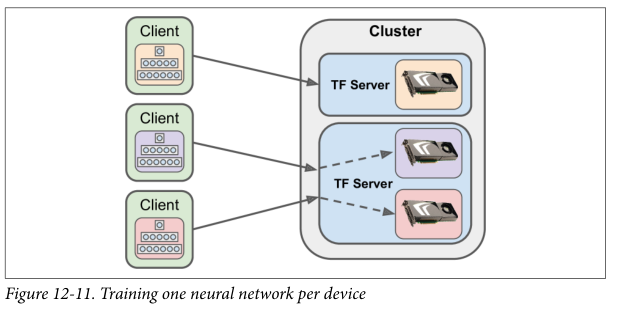

**此解决方案非常适合超参数调整**：

* 集群中的每个设备都将使用自己的一组超参数来训练不同的模型。你拥有的计算能力越强，你可以探索的超参数空间越大。

* 如果你托管每秒接收大量查询（QPS）的Web服务并且你需要神经网络对每个查询进行预测，它也可以完美地工作。只需在群集中的所有设备上复制神经网络，并在所有设备上分派查询。

* 通过添加更多服务器，你可以处理无限数量的QPS（但是，这不会减少处理单个请求所需的时间，因为它仍然需要等待神经网络进行预测）。


另一种选择是使用TensorFlow服务为你的神经网络服务。它是一个开源系统，由Google于2016年2月发布，旨在为机器学习模型（通常使用TensorFlow构建）提供大量查询。它处理模型版本控制，因此你可以轻松地将新版本的网络部署到生产环境中，或者在不中断服务的情况下尝试各种算法，并且可以通过添加更多服务器来承受繁重的负载。有关更多详细信息，请查看https://tensor flow.github.io/serving/.

## 3.2 In-Graph Versus Between-Graph Replication - 图形内与图形间复制

通过简单地将每个神经网络放在不同的设备上，你还可以并行化大型神经网络集合的训练（集合在第7章介绍）。但是，一旦你想要运行集合，你需要聚合每个神经网络所做的各个预测来产生集合的预测，这需要一点协调。


**处理神经网络集合有两种主要方法**（或包含大量独立计算的任何其他图形）：

1. 你可以
    * **首先**创建一个包含每个神经网络的大图，每个固定到不同的设备，加上汇总来自所有神经网络的各个预测所需的计算（见图12-12）。
    * **然后**，你只需为集群中的任何服务器创建一个会话，并让它处理所有事务（包括在汇总它们之前等待所有单个预测可用）。

此方法称为**图形内复制 - in-graph replication**。

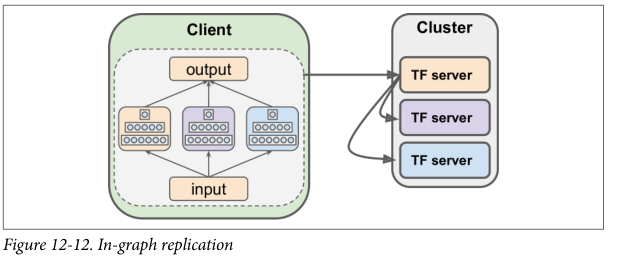

2. 或者，你可以为每个神经网络创建一个单独的图形，并自己处理这些图形之间的同步。这种方法称为**图形间复制 - between-graph replication***。

一种典型的实现是**使用队列协调这些图的执行**（参见图12-13）。

* 一组客户端分别处理一个神经网络，从其专用输入队列读取，并写入其专用预测队列。

* 另一个客户端负责读取输入并将它们推送到所有输入队列（将所有输入复制到每个队列）。

* 最后， 最后一个客户端负责从每个预测队列中读取一个预测并聚合它们以产生集合的预测。

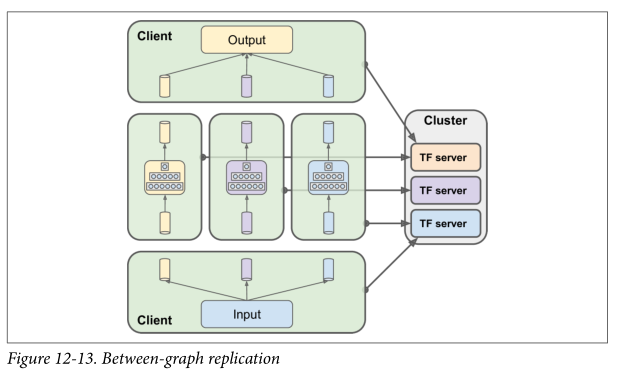

这些解决方案各有利弊。
* 由于你不必管理多个客户端和多个队列，因此实现**图形内复制**更加简单。

* 但是，**图形间复制**更容易组织成有界限的易于测试的模块。而且，它为你提供了更大的灵活性。例如，你可以在聚合器客户端中添加出队超时，以便即使其中一个神经网络客户端崩溃或者一个神经网络花费太长时间来生成其预测，整体也不会失败。

TensorFlow允许你通过传递带有`timeout_in_ms`的`RunOptions`来调用`run（）`函数时指定超时：
```python
with tf.Session([...]) as sess:
    [...]
    run_options = tf.RunOptions()
    run_options.timeout_in_ms = 1000 # 1s timeout
    try:
        pred = sess.run(dequeue_prediction, options=run_options)
    except tf.errors.DeadlineExceededError as ex:
        [...] # the dequeue operation timed out after 1s

```


另一种你可以指定超时的方法是设置会话的`operation_time out_in_ms`配置选项，但在这种情况下，如果任何操作花费的时间超过超时延迟，则`run（）`函数会超时：
```python
config = tf.ConfigProto()
config.operation_timeout_in_ms = 1000 # 1s timeout for every operation

with tf.Session([...], config=config) as sess:
    [...]
    try:
        pred = sess.run(dequeue_prediction)
    except tf.errors.DeadlineExceededError as ex:
        [...] # the dequeue operation timed out after 1s
```

## 3.3 Model Parallelism - 模型并行

到目前为止，我们已经在单个设备上运行每一个神经网络。如果我们想在多个设备上运行单个神经网络怎么办？这需要将你的模型切割成单独的块并在不同的设备上运行每个块。这称为**模型并行**。不幸的是，模型并行非常棘手，它实际上取决于神经网络的体系结构。

对于完全连接的网络，这种方法通常没什么好处（见图12-14）。直观地说，分割模型的一种简单方法**似乎是将每一层放在不同的设备上**，但这不起作用，因为每一层在它可以执行任何操作之前需要等待前一层的输出。

所以也许你可以**垂直切片**——例如，**每个层的左半部分放在一个设备上，右边部分放在另一个设备上**？这稍微好一点，因为每一层的两半确实可以并行工作，但问题是下一层的每一半都需要输出两半，所以会有很多**跨设备通信**（由虚线箭头表示）。这很可能完全抵消了并行计算的好处，因为跨设备通信很慢（特别是如果它跨越不同的机器）。

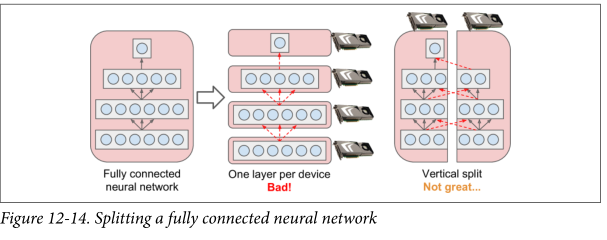

但是，正如我们将在第13章中看到的那样，一些神经网络架构，如卷积神经网络，包含仅部分连接到较低层的网络层，因此以一种有效的方式跨设备分发块更容易。

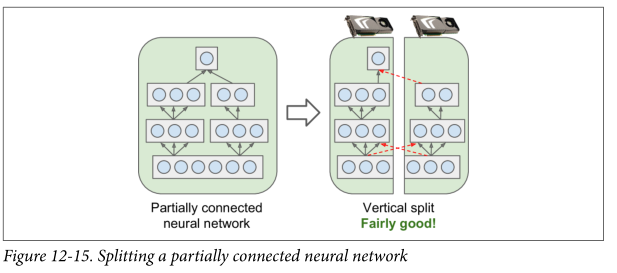

此外，正如我们将在第14章中看到的，一些深度递归神经网络由几层存储单元组成（见图12-16的左侧）。时间 $t$ 的单元输出在时间$t + 1$反馈到其输入（如图12-16右侧所示，你可以更清楚地看到）。

如果你将这样的网络水平分割，将每一层放在不同的设备上，那么在第一步中只有一个设备处于活动状态，在第二步中，两个设备将处于活动状态，并且当信号传播到输出层时，所有设备将同时激活。此时仍然有很多跨设备通信正在进行，但由于每个单元可能相当复杂，并行运行多个单元的好处往往超过通信损失。



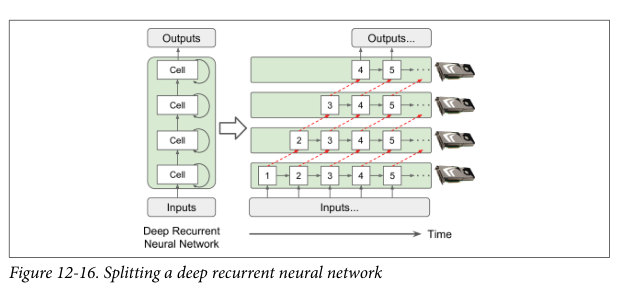

简而言之，模型并行性可以加速运行或训练某些类型的神经网络，但不是全部，它需要特别小心和调整，例如确保需要在同一台机器上运行最多的设备。


## 3.4 Data Parallelism - 数据并行

并行化神经网络训练的另一种方法是在每台设备上复制它，在所有副本上同时运行训练步骤，每个副本使用不同的小批量，
然后聚合梯度以更新模型参数。这称为**数据并行**（见图12-17）。

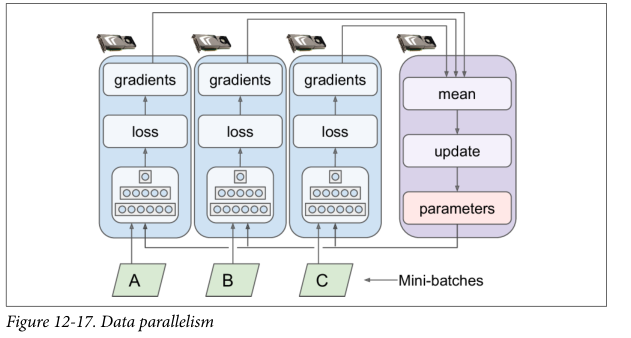

这种方法有两种变体：**同步更新**和**异步更新**。

**3.4.1 Synchronous updates - 同步更新**

通过同步更新，在计算平均值并应用结果之前，聚合器等待所有梯度变得可用（即，使用聚合梯度来更新模型参数）。一旦副本完成其梯度计算，它必须等待参数更新，然后才能进入下一个小批量。

缺点是
* 某些设备可能比其他设备慢，所以其他设备设备必须在每一步都等待它们。

* 此外，几乎同时（紧接在应用梯度之后）将参数复制到每个设备，这可能使参数服务器的带宽饱和。


为了减少每一步的等待时间，你可以忽略最慢的几个副本的梯度（通常为~10％）。例如，你可以运行20个副本，但只聚合梯度
每一步最快的18个复制品，只是忽略最后2个的梯度。一旦参数更新，前18个副本就可以立即重新开始工作，而不必等待2个最慢的副本。此设置通常被描述为**具有18个副本和2个备用副本(having 18 replicas plus 2 spare replicas)**。


**3.4.2 Asynchronous updates - 异步更新**

通过异步更新，每当副本完成梯度计算时，它立即使用它们来更新模型参数。
* 没有聚合（删除图12-17中的“mean”步骤），没有同步。
* 副本只是独立于其他副本而工作。由于没有等待其他副本，这种方法每分钟运行更多的训练步骤。
* 此外，虽然每个步骤仍然需要将参数复制到每个设备，但是每个副本在不同时间发生这种情况，因此带宽饱和的风险降低。


使用异步更新的数据并行是一个有吸引力的选择，因为它简单，没有同步延迟，更好地利用了带宽。

然而，虽然它在实践中运作得相当好，但它的工作原理几乎令人惊讶！实际上，
* 当复制品基于某些参数值完成计算梯度时，这些参数将被其他复制品多次更新（如果有N个复制品则平均N-1次）并且不能保证梯度计算仍将指向正确的方向（见图12-18）。

* 当梯度严重过时时，它们被称为**过时梯度**：它们可以减缓收敛，引入噪音和摆动效果（学习曲线可能包含临时振荡），或者它们甚至可以使训练算法发散。

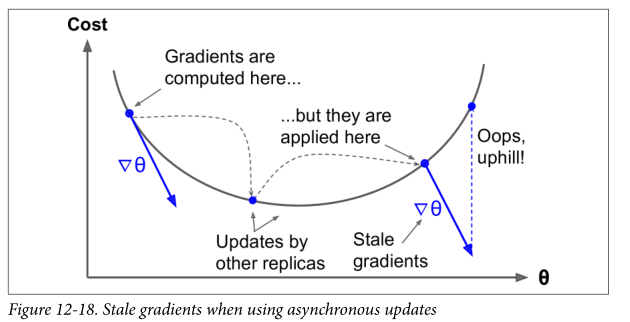

有几种方法可以减少**陈旧梯度(stale gradients)** 的影响：
* 降低学习率。
* 丢弃过时的梯度或缩小它们。
* 调整小批量。
* 仅使用一个副本启动前几个时期（这称为预热阶段）。在训练开始时，当梯度通常较大且参数尚未稳定在成本函数的谷中时，陈旧的梯度往往更具破坏性，所以不同的复制品可能会将参数推向完全不同的方向。


Google Brain团队于2016年4月发表的一篇论文对各种方法进行基准测试，发现使用一些备用副本进行同步更新的数据并行性是最有效的，不仅收敛速度更快，而且还能产生更好的模型。然而，这仍然是一个活跃的研究领域，所以你不应该排除异步更新。

**3.4.3 Bandwidth saturation - 带宽饱和度**

无论你使用同步还是异步更新，数据并行仍然需要在每个训练步骤开始时将模型参数从参数服务器传送到每个副本，并且在每个训练步骤结束时将另一个方向的梯度传送到另一个方向。

不幸的是，这意味着总是有一点，添加额外的GPU根本不会提高性能，因为将数据移入和移出GPU RAM（以及可能穿过网络）所花费的时间将超过分割计算负载所获得的加速。此时，添加更多GPU只会增加饱和度并减慢训练速度。


对于某些模型，通常相对较小并且在非常大的训练集上训练，你通常可以在单个GPU上使用单个GPU训练模型。


**对于大型密集模型，饱和度更严重，因为它们具有许多参数和梯度来传递**。对于小型模型来说不那么严重（但并行化增益很小）并且对于大型稀疏模型也是如此，因为梯度通常大多为零，因此可以有效地进行通信。

谷歌大脑项目的发起人兼负责人杰夫迪恩报告说，
* 在50个GPU上为密集模型分配计算时，典型的加速比为25-40倍，
* 而在500个GPU中训练的稀疏模型则为300倍加速。

如你所见，稀疏模型确实可以更好地扩展。以下是一些具体的例子：

* 神经机器翻译：8个GPU加速6倍

* Inception / ImageNet：50个GPU上加速32倍

* RankBrain：500 GPU上的300倍加速

这些数字代表了2016年第一季度的最新技术水平。除了针对密集模型的几十个GPU或用于稀疏模型的几百个GPU之外，饱和度开始增加并且性能降低。

有很多研究正在解决这个问题（探索对等体系结构而不是集中式参数服务器，使用有损模型压缩，优化副本需要通信的时间和内容，等等），

因此，在未来几年内并行化神经网络可能会取得很大进展。与此同时，你可以**采取一些简单的步骤来降低饱和度问题**：

* 将GPU分组在几台服务器上，而不是将它们分散到多台服务器上。这样可以避免不必要的网络跳跃。

* 在多个参数服务器之间对参数进行分片（如前所述）。

* 将模型参数的浮点精度从32位（tf.float32）降低到16位（tf.bfloat16）。这将减少传输数据量的一半，而对收敛速度或模型的性能不会产生太大影响。

虽然训练神经网络的16位精度是最小的，**但训练后实际上可以降低到8位精度**，以减小模型的大小并加快计算速度。这称为**量化神经网络**。它对于在移动电话上部署和运行预训练模型特别有用。 请参阅Pete Warden关于此主题的精彩帖子。


**3.4.4 TensorFlow implementation - TensorFlow实现**

使用TensorFlow实现数据并行，

* 首先需要选择是否需要**图形内复制或图形间复制**，
* 以及是否需要**同步更新或异步更新**。

让我们来看看如何实现每个组合（有关完整的代码示例，请参阅练习和Jupyter笔记本）。

1. 使用**图形内复制+同步更新**，你可以构建一个包含所有模型副本（放置在不同设备上）的大图，以及一些节点聚合所有梯度并将它们提供给优化器。你的代码会打开与集群的会话，然后简单的重复运行训练操作。
  
2. 通过**图形内复制+异步更新**，你也可以创建一个大图，但是每个副本使用一个优化器，并且每个副本运行一个线程，重复运行副本的优化器。

3. 使用**图形间复制+异步更新**，你运行多个独立客户端（通常在单独的进程中），每个训练模型复制品就好像它是世界上独一无二的，但参数实际上与其他副本共享（使用资源容器）。

4. 使用**图形间复制+同步更新**，再次运行多个客户端，每个客户端根据共享参数训练模型副本，但这次将优化器（例如，MomentumOptimizer）包装在SyncReplicasOptimizer中。
   * 每个副本使用此优化器，因为它将使用任何其他优化器，但是在这个引擎盖下，这个优化器将梯度发送到一组队列（每个变量一个），由一个副本的SyncReplicasOptimizer读取，称为**主要队列**。
   * 主要聚合梯度并应用它们，然后将**token**写入每个副本的 **token queue** ，发出信号表明它可以继续并计算下一个梯度。

这种方法支持**备用副本 -  spare replicas**。

如果你完成练习，你将实施这四种解决方案中的每一种。你可以轻松地应用所学知识，在数十台服务器和GPU上训练大型深度神经网络！

在接下来的章节中，**我们将讨论一些更重要的神经网络架构，然后再解决强化学习问题**。

# Local server

In [2]:
import tensorflow as tf

In [3]:
c = tf.constant("Hello distributed TensorFlow!")
server = tf.train.Server.create_local_server()

In [4]:
with tf.Session(server.target) as sess:
    print(sess.run(c))

b'Hello distributed TensorFlow!'


# Cluster

In [5]:
cluster_spec = tf.train.ClusterSpec({
    "ps": [
        "127.0.0.1:2221",  # /job:ps/task:0
        "127.0.0.1:2222",  # /job:ps/task:1
    ],
    "worker": [
        "127.0.0.1:2223",  # /job:worker/task:0
        "127.0.0.1:2224",  # /job:worker/task:1
        "127.0.0.1:2225",  # /job:worker/task:2
    ]})

In [6]:
task_ps0 = tf.train.Server(cluster_spec, job_name="ps", task_index=0)
task_ps1 = tf.train.Server(cluster_spec, job_name="ps", task_index=1)
task_worker0 = tf.train.Server(cluster_spec, job_name="worker", task_index=0)
task_worker1 = tf.train.Server(cluster_spec, job_name="worker", task_index=1)
task_worker2 = tf.train.Server(cluster_spec, job_name="worker", task_index=2)

# Pinning operations across devices and servers

In [7]:
reset_graph()

with tf.device("/job:ps"):
    a = tf.Variable(1.0, name="a")

with tf.device("/job:worker"):
    b = a + 2

with tf.device("/job:worker/task:1"):
    c = a + b

In [8]:
with tf.Session("grpc://127.0.0.1:2221") as sess:
    sess.run(a.initializer)
    print(c.eval())

4.0


In [9]:
reset_graph()

with tf.device(tf.train.replica_device_setter(
        ps_tasks=2,
        ps_device="/job:ps",
        worker_device="/job:worker")):
    v1 = tf.Variable(1.0, name="v1")  # pinned to /job:ps/task:0 (defaults to /cpu:0)
    v2 = tf.Variable(2.0, name="v2")  # pinned to /job:ps/task:1 (defaults to /cpu:0)
    v3 = tf.Variable(3.0, name="v3")  # pinned to /job:ps/task:0 (defaults to /cpu:0)
    s = v1 + v2            # pinned to /job:worker (defaults to task:0/cpu:0)
    with tf.device("/task:1"):
        p1 = 2 * s         # pinned to /job:worker/task:1 (defaults to /cpu:0)
        with tf.device("/cpu:0"):
            p2 = 3 * s     # pinned to /job:worker/task:1/cpu:0

config = tf.ConfigProto()
config.log_device_placement = True

with tf.Session("grpc://127.0.0.1:2221", config=config) as sess:
    v1.initializer.run()

# Readers – the old way

In [10]:
reset_graph()

In [11]:
default1 = tf.constant([5.])
default2 = tf.constant([6])
default3 = tf.constant([7])
dec = tf.decode_csv(tf.constant("1.,,44"),
                    record_defaults=[default1, default2, default3])
with tf.Session() as sess:
    print(sess.run(dec))

[1.0, 6, 44]


In [12]:
reset_graph()

test_csv = open("my_test.csv", "w")
test_csv.write("x1, x2 , target\n")
test_csv.write("1.,, 0\n")
test_csv.write("4., 5. , 1\n")
test_csv.write("7., 8. , 0\n")
test_csv.close()

filename_queue = tf.FIFOQueue(capacity=10, dtypes=[tf.string], shapes=[()])
filename = tf.placeholder(tf.string)
enqueue_filename = filename_queue.enqueue([filename])
close_filename_queue = filename_queue.close()

reader = tf.TextLineReader(skip_header_lines=1)
key, value = reader.read(filename_queue)

x1, x2, target = tf.decode_csv(value, record_defaults=[[-1.], [-1.], [-1]])
features = tf.stack([x1, x2])

instance_queue = tf.RandomShuffleQueue(
    capacity=10, min_after_dequeue=2,
    dtypes=[tf.float32, tf.int32], shapes=[[2],[]],
    name="instance_q", shared_name="shared_instance_q")
enqueue_instance = instance_queue.enqueue([features, target])
close_instance_queue = instance_queue.close()

minibatch_instances, minibatch_targets = instance_queue.dequeue_up_to(2)

with tf.Session() as sess:
    sess.run(enqueue_filename, feed_dict={filename: "my_test.csv"})
    sess.run(close_filename_queue)
    try:
        while True:
            sess.run(enqueue_instance)
    except tf.errors.OutOfRangeError as ex:
        print("No more files to read")
    sess.run(close_instance_queue)
    try:
        while True:
            print(sess.run([minibatch_instances, minibatch_targets]))
    except tf.errors.OutOfRangeError as ex:
        print("No more training instances")

No more files to read
[array([[ 4.,  5.],
       [ 1., -1.]], dtype=float32), array([1, 0])]
[array([[7., 8.]], dtype=float32), array([0])]
No more training instances


In [13]:
#coord = tf.train.Coordinator()
#threads = tf.train.start_queue_runners(coord=coord)
#filename_queue = tf.train.string_input_producer(["test.csv"])
#coord.request_stop()
#coord.join(threads)

# Queue runners and coordinators

In [14]:
reset_graph()

filename_queue = tf.FIFOQueue(capacity=10, dtypes=[tf.string], shapes=[()])
filename = tf.placeholder(tf.string)
enqueue_filename = filename_queue.enqueue([filename])
close_filename_queue = filename_queue.close()

reader = tf.TextLineReader(skip_header_lines=1)
key, value = reader.read(filename_queue)

x1, x2, target = tf.decode_csv(value, record_defaults=[[-1.], [-1.], [-1]])
features = tf.stack([x1, x2])

instance_queue = tf.RandomShuffleQueue(
    capacity=10, min_after_dequeue=2,
    dtypes=[tf.float32, tf.int32], shapes=[[2],[]],
    name="instance_q", shared_name="shared_instance_q")
enqueue_instance = instance_queue.enqueue([features, target])
close_instance_queue = instance_queue.close()

minibatch_instances, minibatch_targets = instance_queue.dequeue_up_to(2)

n_threads = 5
queue_runner = tf.train.QueueRunner(instance_queue, [enqueue_instance] * n_threads)
coord = tf.train.Coordinator()

with tf.Session() as sess:
    sess.run(enqueue_filename, feed_dict={filename: "my_test.csv"})
    sess.run(close_filename_queue)
    enqueue_threads = queue_runner.create_threads(sess, coord=coord, start=True)
    try:
        while True:
            print(sess.run([minibatch_instances, minibatch_targets]))
    except tf.errors.OutOfRangeError as ex:
        print("No more training instances")

[array([[ 4.,  5.],
       [ 1., -1.]], dtype=float32), array([1, 0])]
[array([[7., 8.]], dtype=float32), array([0])]
No more training instances


In [15]:
reset_graph()

def read_and_push_instance(filename_queue, instance_queue):
    reader = tf.TextLineReader(skip_header_lines=1)
    key, value = reader.read(filename_queue)
    x1, x2, target = tf.decode_csv(value, record_defaults=[[-1.], [-1.], [-1]])
    features = tf.stack([x1, x2])
    enqueue_instance = instance_queue.enqueue([features, target])
    return enqueue_instance

filename_queue = tf.FIFOQueue(capacity=10, dtypes=[tf.string], shapes=[()])
filename = tf.placeholder(tf.string)
enqueue_filename = filename_queue.enqueue([filename])
close_filename_queue = filename_queue.close()

instance_queue = tf.RandomShuffleQueue(
    capacity=10, min_after_dequeue=2,
    dtypes=[tf.float32, tf.int32], shapes=[[2],[]],
    name="instance_q", shared_name="shared_instance_q")

minibatch_instances, minibatch_targets = instance_queue.dequeue_up_to(2)

read_and_enqueue_ops = [read_and_push_instance(filename_queue, instance_queue) for i in range(5)]
queue_runner = tf.train.QueueRunner(instance_queue, read_and_enqueue_ops)

with tf.Session() as sess:
    sess.run(enqueue_filename, feed_dict={filename: "my_test.csv"})
    sess.run(close_filename_queue)
    coord = tf.train.Coordinator()
    enqueue_threads = queue_runner.create_threads(sess, coord=coord, start=True)
    try:
        while True:
            print(sess.run([minibatch_instances, minibatch_targets]))
    except tf.errors.OutOfRangeError as ex:
        print("No more training instances")



[array([[ 4.,  5.],
       [ 1., -1.]], dtype=float32), array([1, 0])]
[array([[7., 8.]], dtype=float32), array([0])]
No more training instances


# Setting a timeout

In [16]:
reset_graph()

q = tf.FIFOQueue(capacity=10, dtypes=[tf.float32], shapes=[()])
v = tf.placeholder(tf.float32)
enqueue = q.enqueue([v])
dequeue = q.dequeue()
output = dequeue + 1

config = tf.ConfigProto()
config.operation_timeout_in_ms = 1000

with tf.Session(config=config) as sess:
    sess.run(enqueue, feed_dict={v: 1.0})
    sess.run(enqueue, feed_dict={v: 2.0})
    sess.run(enqueue, feed_dict={v: 3.0})
    print(sess.run(output))
    print(sess.run(output, feed_dict={dequeue: 5}))
    print(sess.run(output))
    print(sess.run(output))
    try:
        print(sess.run(output))
    except tf.errors.DeadlineExceededError as ex:
        print("Timed out while dequeuing")


2.0
6.0
3.0
4.0
Timed out while dequeuing


# Data API

The Data API, introduced in TensorFlow 1.4, makes reading data efficiently much easier.

In [17]:
tf.reset_default_graph()

Let's start with a simple dataset composed of three times the integers 0 to 9, in batches of 7:

In [18]:
dataset = tf.data.Dataset.from_tensor_slices(np.arange(10))
dataset = dataset.repeat(3).batch(7)

The first line creates a dataset containing the integers 0 through 9. The second line creates a new dataset based on the first one, repeating its elements three times and creating batches of 7 elements. As you can see, we start with a source dataset, then we chain calls to various methods to apply transformations to the data.

Next, we create a one-shot-iterator to go through this dataset just once, and we call its `get_next()` method to get a tensor that represents the next element.

In [19]:
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

Let's repeatedly evaluate `next_element` to go through the dataset. When there are not more elements, we get an `OutOfRangeError`:

In [20]:
with tf.Session() as sess:
    try:
        while True:
            print(next_element.eval())
    except tf.errors.OutOfRangeError:
        print("Done")

[0 1 2 3 4 5 6]
[7 8 9 0 1 2 3]
[4 5 6 7 8 9 0]
[1 2 3 4 5 6 7]
[8 9]
Done


Great! It worked fine.

Note that, as always, a tensor is only evaluated once each time we run the graph (`sess.run()`): so even if we evaluate multiple tensors that all depend on `next_element`, it is only evaluated once. This is true as well if we ask for `next_element` to be evaluated twice in just one run:

In [21]:
with tf.Session() as sess:
    try:
        while True:
            print(sess.run([next_element, next_element]))
    except tf.errors.OutOfRangeError:
        print("Done")

[array([0, 1, 2, 3, 4, 5, 6]), array([0, 1, 2, 3, 4, 5, 6])]
[array([7, 8, 9, 0, 1, 2, 3]), array([7, 8, 9, 0, 1, 2, 3])]
[array([4, 5, 6, 7, 8, 9, 0]), array([4, 5, 6, 7, 8, 9, 0])]
[array([1, 2, 3, 4, 5, 6, 7]), array([1, 2, 3, 4, 5, 6, 7])]
[array([8, 9]), array([8, 9])]
Done


The `interleave()` method is powerful but a bit tricky to grasp at first. The easiest way to understand it is to look at an example:

In [22]:
tf.reset_default_graph()

In [23]:
dataset = tf.data.Dataset.from_tensor_slices(np.arange(10))
dataset = dataset.repeat(3).batch(7)
dataset = dataset.interleave(
    lambda v: tf.data.Dataset.from_tensor_slices(v),
    cycle_length=3,
    block_length=2)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

In [24]:
with tf.Session() as sess:
    try:
        while True:
            print(next_element.eval(), end=",")
    except tf.errors.OutOfRangeError:
        print("Done")

0,1,7,8,4,5,2,3,9,0,6,7,4,5,1,2,8,9,6,3,0,1,2,8,9,3,4,5,6,7,Done


Because `cycle_length=3`, the new dataset starts by pulling 3 elements from the previous dataset: that's `[0,1,2,3,4,5,6]`, `[7,8,9,0,1,2,3]` and `[4,5,6,7,8,9,0]`. Then it calls the lambda function we gave it to create one dataset for each of the elements. Since we use `Dataset.from_tensor_slices()`, each dataset is going to return its elements one by one. Next, it pulls two items (since `block_length=2`) from each of these three datasets, and it iterates until all three datasets are out of items: 0,1 (from 1st), 7,8 (from 2nd), 4,5 (from 3rd), 2,3 (from 1st), 9,0 (from 2nd), and so on until 8,9 (from 3rd), 6 (from 1st), 3 (from 2nd), 0 (from 3rd). Next it tries to pull the next 3 elements from the original dataset, but there are just two left: `[1,2,3,4,5,6,7]` and `[8,9]`. Again, it creates datasets from these elements, and it pulls two items from each until both datasets are out of items: 1,2 (from 1st), 8,9 (from 2nd), 3,4 (from 1st), 5,6 (from 1st), 7 (from 1st). Notice that there's no interleaving at the end since the arrays do not have the same length.

# Readers – the new way

Instead of using a source dataset based on `from_tensor_slices()` or `from_tensor()`, we can use a reader dataset. It handles most of the complexity for us (e.g., threads):

In [25]:
tf.reset_default_graph()

In [26]:
filenames = ["my_test.csv"]

In [27]:
dataset = tf.data.TextLineDataset(filenames)

We still need to tell it how to decode each line:

In [28]:
def decode_csv_line(line):
    x1, x2, y = tf.decode_csv(
        line, record_defaults=[[-1.], [-1.], [-1.]])
    X = tf.stack([x1, x2])
    return X, y

Next, we can apply this decoding function to each element in the dataset using `map()`:

In [29]:
dataset = dataset.skip(1).map(decode_csv_line)

Finally, let's create a one-shot iterator:

In [30]:
it = dataset.make_one_shot_iterator()
X, y = it.get_next()

In [31]:
with tf.Session() as sess:
    try:
        while True:
            X_val, y_val = sess.run([X, y])
            print(X_val, y_val)
    except tf.errors.OutOfRangeError as ex:
        print("Done")


[ 1. -1.] 0.0
[4. 5.] 1.0
[7. 8.] 0.0
Done


# Exercise solutions

**1. to 7.**

请移步我的简书[Chapter -12 Exercise(1-7)](https://www.jianshu.com/p/de7510eea461)

**Coming soon**